In [13]:
#!/usr/bin/env python3

import sys
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import redpitaya_scpi as scpi

IP = '169.254.85.44'        # 'rp-f066c8.local'
rp_s = scpi.scpi(IP)



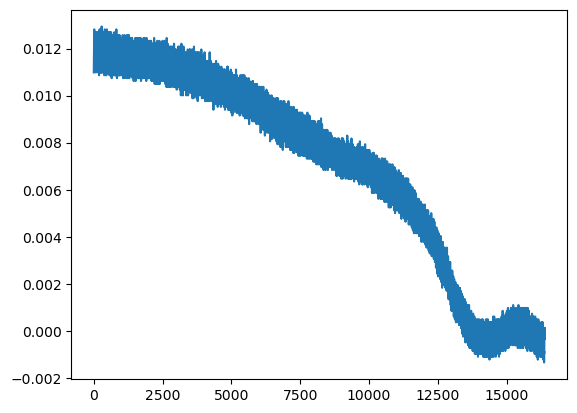

In [127]:
wave_form = 'SAWU'
#wave_form = 'sine'
freq = 0.1
ampl = 1


# Reset Generation and Acquisition
rp_s.tx_txt('GEN:RST')
rp_s.tx_txt('ACQ:RST')

##### Generation #####
rp_s.tx_txt('SOUR1:FUNC ' + str(wave_form).upper())
rp_s.tx_txt('SOUR1:FREQ:FIX ' + str(freq))
rp_s.tx_txt('SOUR1:VOLT ' + str(ampl))

rp_s.tx_txt('SOUR1:BURS:STAT BURST')        # Mode set to BURST
rp_s.tx_txt('SOUR1:BURS:NCYC 2')            # 3 periods in each burst

##### Acqusition #####
rp_s.tx_txt('ACQ:DEC 65536')
rp_s.tx_txt('ACQ:TRig:LEV 0')
rp_s.tx_txt('ACQ:TRig:DLY 8192')

rp_s.tx_txt('ACQ:START')
time.sleep(1)
rp_s.tx_txt('ACQ:TRig AWG_PE')
rp_s.tx_txt('OUTPUT1:STATE ON')
time.sleep(1)

rp_s.tx_txt('SOUR1:TRig:INT')

# Wait for trigger
while 1:
    rp_s.tx_txt('ACQ:TRig:STAT?')           # Get Trigger Status
    if rp_s.rx_txt() == 'TD':               # Triggerd?
        break

## ! OS 2.00 or higher only ! ##
while 1:
    rp_s.tx_txt('ACQ:TRig:FILL?')
    if rp_s.rx_txt() == '1':
        break

# Read data and plot
rp_s.tx_txt('ACQ:SOUR1:DATA?')              # Read full buffer (source 1)
data_string = rp_s.rx_txt()                 # data into a string

# Remove brackets and empty spaces + string => float
data_string = data_string.strip('{}\n\r').replace("  ", "").split(',')
data = list(map(float, data_string))        # transform data into float

plt.plot(data)
plt.show()

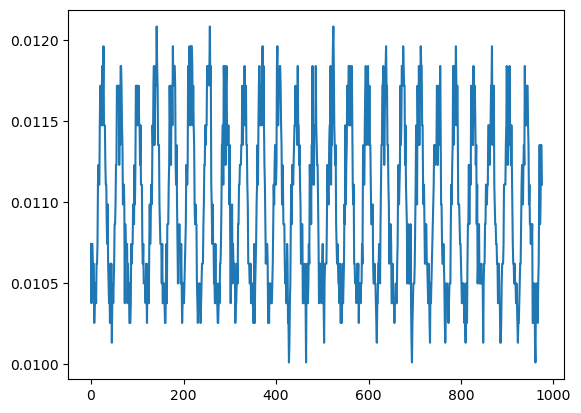

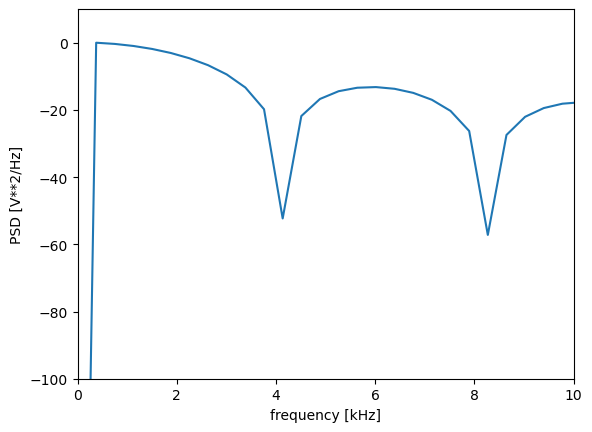

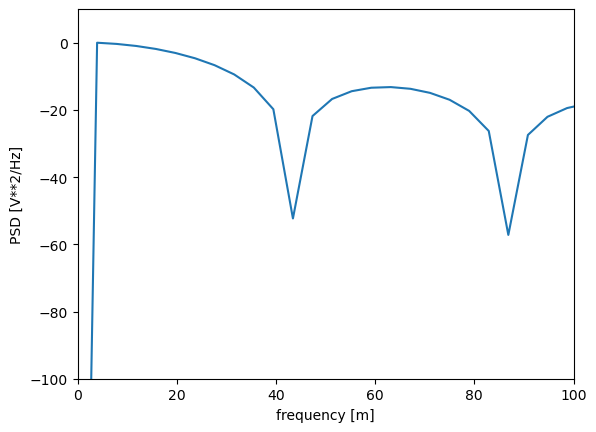

In [123]:
fs=126e6/64

plt.plot(data[100:100+976])
plt.show()

data_zp=np.concatenate((data[100:100+476],np.zeros(10*len(data[100:100+476]))))

f, Pxx_den = signal.periodogram(data_zp, fs)
plt.plot(f/1e3, 10*np.log10(Pxx_den/np.max(np.abs(Pxx_den))))
plt.ylim([-100, 10])
plt.xlim([0,10])
plt.xlabel('frequency [kHz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

d=3e8*0.7*f/(1e3*20e6)

plt.plot(d, 10*np.log10(Pxx_den/np.max(np.abs(Pxx_den))))
plt.ylim([-100, 10])
plt.xlim([0,100])
plt.xlabel('frequency [m]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()